<a href="https://colab.research.google.com/github/sutummala/selfQCNet/blob/main/QC_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the drive and required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import GlobalAveragePooling3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc

## Normalization

In [ ]:
# normalizing the input to have values between zero and one to make them suitable for further analysis
def normalize(input):
  norm_input = []
  print(f'shape of input is {np.shape(input[0])}')
  for i in range(np.shape(input)[0]):
    norm_in = (input[i]-np.min(input[i]))/(np.max(input[i])-np.min(input[i]))
    norm_input.append(norm_in)
  return np.array(norm_input)

## cropping

In [ ]:
def crop_input(input, d_s_factor):
  
  if d_s_factor == 2:
    input = input[:, 6:86, 6:102, 6:86]
  elif d_s_factor == 4:
    input = input[:, 3:43, 4:52, 3:43]

  return input

## Load the required correctly aligned and artifically misaligned images

In [ ]:
t1_align = np.load('/content/drive/MyDrive/UnsupervisedQC/T1-mni-dsf2.npy')
t1_align = np.float32(t1_align)
print(t1_align.shape)
t1_align = crop_input(t1_align, 2)
t1_align = np.expand_dims(t1_align, axis = -1)

print('values before normalization', np.min(t1_align[0]), np.max(t1_align[0]))
t1_align_norm = normalize(t1_align)
print(t1_align_norm.shape)
print('values after normalization', np.min(t1_align_norm[0]), np.max(t1_align_norm[0]))
del t1_align

(215, 91, 109, 91)
values before normalization -26.19167 830.7939
shape of input is (80, 96, 80, 1)
(215, 80, 96, 80, 1)
values after normalization 0.0 1.0


In [ ]:
t1_align_f = np.load('/content/drive/MyDrive/UnsupervisedQC/T1-mni-HCP-am-250threshold.npy')
t1_align_f = np.float32(t1_align_f)
t1_align_f = crop_input(t1_align_f, 2)
t1_align_f = np.expand_dims(t1_align_f, axis = -1)

print('values before normalization', np.min(t1_align_f[0]), np.max(t1_align_f[0]))
t1_align_f_norm = normalize(t1_align_f)
print(t1_align_f_norm.shape)
print('values after normalization', np.min(t1_align_f_norm[0]), np.max(t1_align_f_norm[0]))
del t1_align_f

values before normalization -306.92776 3532.389
shape of input is (80, 96, 80, 1)
(250, 80, 96, 80, 1)
values after normalization 0.0 1.0


## Model creation

In [ ]:
activation = tf.keras.activations.relu
kernal_initializer = tf.keras.initializers.glorot_normal
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
def create_model_single_conv_noupsamp(input_shape):
  input_layer = Input(shape=input_shape, dtype="float32", name="INPUT")

  x = Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding="same", kernel_initializer=kernal_initializer)(input_layer)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = MaxPooling3D(strides=2)(x)

  x = Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = MaxPooling3D(strides=2)(x)

  x = Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = MaxPooling3D(strides=2)(x)

  volumeSize = K.int_shape(x)
  x = Flatten()(x)

  x = Dense(256, activation=activation, kernel_initializer=tf.keras.initializers.glorot_normal, activity_regularizer=regularizers.l2(1e-05))(x)

  x = Dense(128, activation=activation, kernel_initializer=tf.keras.initializers.glorot_normal,  activity_regularizer=regularizers.l2(1e-05), name="CODE")(x)

  x = Dense(256, activation=activation, kernel_initializer=tf.keras.initializers.glorot_normal, activity_regularizer=regularizers.l2(1e-05))(x)

  x = Dense(np.prod(volumeSize[1:]), kernel_initializer=tf.keras.initializers.glorot_normal)(x)

  x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3], volumeSize[4]))(x)
  
  x = UpSampling3D(size = (2, 2, 2))(x)
  x = Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  
  x = UpSampling3D(size = (2, 2, 2))(x)
  x = Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  
  x = UpSampling3D(size = (2, 2, 2))(x)
  x = Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding="same", kernel_initializer=kernal_initializer)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  

  x = Conv3D(1, (3, 3, 3), strides=(1, 1, 1),  padding="same", kernel_initializer=kernal_initializer, name = "OUTPUT")(x)
  x = Activation(tf.keras.activations.sigmoid)(x)

  autoencoder = Model(input_layer, x)
  autoencoder.summary()

  print("Model created successfully")
  return autoencoder

In [ ]:
input_shape = (t1_align_norm.shape[1], t1_align_norm.shape[2], t1_align_norm.shape[3], 1)
autoencoder = create_model_single_conv_noupsamp(input_shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 80, 96, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 80, 96, 80, 32)    896       
                                                                 
 batch_normalization (BatchN  (None, 80, 96, 80, 32)   128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 80, 96, 80, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 40, 48, 40, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 48, 40, 64)    55360 

## Compilation of the model

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.005), loss = tf.keras.losses.MeanSquaredError())

In [ ]:
autoencoder.fit(t1_align_norm[:300], t1_align_norm[:300], validation_split = 0.1, batch_size = 8, epochs = 20, shuffle = True)

## save and load the weights of the model

In [ ]:
prefix = "/content/drive/MyDrive/Weights/"
path = prefix  + "hcp_weights/"



In [ ]:
os.mkdir(path)

In [ ]:
autoencoder.save_weights(path+"HCP_300_T2mni_upsamp_L2_bias", save_format='tf')

In [ ]:
autoencoder.load_weights(path+"HCP_300_mni_upsamp_L2SR")

## Threshold calculation & Performance evaluation.

In [ ]:
t1_align_norm_sel = t1_align_norm[300:350]
t1_align_f_sel = t1_align_f_norm
t1_align_norm_sel = np.append(t1_align_norm_sel, t1_align_f_sel, axis = 0 )
t1_align_norm_sel.shape


(300, 80, 96, 80, 1)

In [ ]:
testing_labels = np.append(np.zeros(50), np.ones(len(t1_align_f_sel)))
print(testing_labels)

In [ ]:
losses_train = [] 
p = tf.keras.losses.MeanSquaredError()
for i in range(np.shape(t1_align_norm_sel)[0]):
  predicted_train = autoencoder.predict(t1_align_norm_sel[i:i+1])
  losses_train.append(p(predicted_train, t1_align_norm_sel[i:i+1]).numpy())
print(losses_train)

In [ ]:
import sklearn

labels = testing_labels
mses = losses_train

y_true = labels
y_score = mses

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC on Validation dataset ")
plt.legend(loc="lower right")
plt.show()

diff = np.abs(np.array(fpr) - np.array(tpr))
max_diff = np.max(diff)
index_of_max_diff = np.argmax(diff)
threshold_at_max_diff =  thresholds[index_of_max_diff]
print("threshold_at_max_diff = ", threshold_at_max_diff)

In [ ]:
wrong_predicts = 0
labels = []
for loss in losses_train:
  if loss >= threshold_at_max_diff:
    labels = labels + [1]
  else:
    labels = labels + [0]
accuracy = accuracy_score(testing_labels, labels)
confusion_matrix = sklearn.metrics.confusion_matrix(testing_labels, labels)
TN = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]
TP = confusion_matrix[1][1]
print("confusion_matrix \n", confusion_matrix)
print(f'accuracy in identifying the correct alignments: {accuracy*100} percent')

confusion_matrix 
 [[ 49   1]
 [  3 247]]
accuracy in identifying the correct alignments: 98.66666666666667 percent


In [ ]:
t1_align_norm_sel_t = t1_align_norm[350:]
t1_align_norm_sel_t.shape

(50, 80, 96, 80, 1)

In [ ]:
losses_test = [] 
for i in range(np.shape(t1_align_norm_sel_t)[0]):
  predicted_test = autoencoder.predict(t1_align_norm_sel_t[i:i+1])
  losses_test.append(p(predicted_test, t1_align_norm_sel_t[i:i+1]).numpy())
print(losses_test)

[0.005913236, 0.0070741354, 0.0053468775, 0.0069335033, 0.008324049, 0.0072536324, 0.0060985335, 0.0058533973, 0.0060419724, 0.009181609, 0.0059048464, 0.008701561, 0.010277496, 0.0057144365, 0.005488973, 0.0058647995, 0.0066005858, 0.006037756, 0.005551012, 0.007051306, 0.0061268588, 0.0076903454, 0.008107291, 0.007201929, 0.013812301, 0.006254665, 0.010309189, 0.0076360805, 0.0051533054, 0.0080378195, 0.006754847, 0.0103642, 0.0060882946, 0.007630795, 0.008825901, 0.008392449, 0.0076888036, 0.0067507965, 0.006702007, 0.006328167, 0.008092552, 0.0059834123, 0.004798258, 0.005756157, 0.0054275487, 0.0070553273, 0.0060853134, 0.005892134, 0.005680378, 0.0077593126]


In [ ]:
testing_labels_t = np.zeros(len(t1_align_norm_sel_t))

In [ ]:
wrong_predicts = 0
labels = []
for loss in losses_test:
  if loss >= threshold_at_max_diff:
    labels = labels + [1]
  else:
    labels = labels + [0]
accuracy = accuracy_score(testing_labels_t, labels)
confusion_matrix = sklearn.metrics.confusion_matrix(testing_labels_t, labels)
print("confusion_matrix \n", confusion_matrix)
print(f'accuracy in identifying the correct alignments: {accuracy*100} percent')

confusion_matrix 
 [[49  1]
 [ 0  0]]
accuracy in identifying the correct alignments: 98.0 percent


## For new test datasets

In [ ]:
  abide_mni = np.load('/content/drive/MyDrive/UnsupervisedQC/T1-mni-dsf2-IOP.npy')
  t1_mni_a = np.float32(abide_mni)
  t1_mni_a = crop_input(t1_mni_a, 2)
  t1_mni_a = np.expand_dims(t1_mni_a, axis = -1)

  print('values before normalization', np.min(t1_mni_a[0]), np.max(t1_mni_a[0]))
  t1_mni_a_norm = normalize(t1_mni_a)
  print(t1_mni_a_norm.shape)
  print('values after normalization', np.min(t1_mni_a_norm[0]), np.max(t1_mni_a_norm[0]))
  del abide_mni, t1_mni_a

values before normalization -608.0 12581.0
shape of input is (80, 96, 80, 1)
(320, 80, 96, 80, 1)
values after normalization 0.0 1.0


In [ ]:
t1_mni_a_f_norm = np.load('/content/drive/MyDrive/UnsupervisedQC/T2-mni-HCP-am-2000-fullprocessed.npy')

In [ ]:
testing_labels = np.append(np.zeros(50), np.ones(len(t1_mni_a_f_norm)))
print(testing_labels)

In [ ]:
t1_mni_a_f_norm = np.append(t1_mni_a_norm[:50], t1_mni_a_f_norm, axis = 0 )
t1_mni_a_f_norm.shape

(370, 80, 96, 80, 1)

In [ ]:
losses_test = [] 
p = tf.keras.losses.MeanSquaredError()
for i in range(np.shape(t1_abide)[0]):
  predicted_test = autoencoder.predict(t1_abide[i:i+1])
  losses_test.append(p(predicted_test, t1_abide[i:i+1]).numpy())
print(losses_test)


AUC:  0.9941249999999999


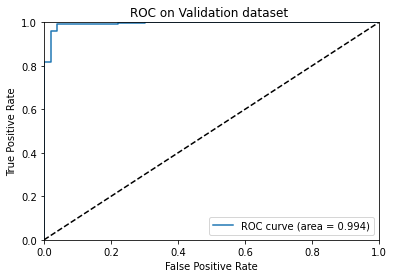

threshold_at_max_diff =  0.012769941


'\nval_pred_labels = mses > threshold\nprint(val_pred_labels, mses)\n# to get max of predictions\n    \nreport = classification_report(labels, val_pred_labels)\np_score = precision_score(labels, val_pred_labels)\nr_score = recall_score(labels, val_pred_labels)\nf1 = f1_score(labels, val_pred_labels)\nmatthews = matthews_corrcoef(labels, val_pred_labels)\nbalanced_accuracy = balanced_accuracy_score(labels, val_pred_labels)\nconfusion_matrix = sklearn.metrics.confusion_matrix(labels, val_pred_labels)\nTN = confusion_matrix[0][0]\nFP = confusion_matrix[0][1]\nFN = confusion_matrix[1][0]\nTP = confusion_matrix[1][1]\nspecificity = TN/(TN+FP)\naccuracy = sklearn.metrics.accuracy_score(labels, val_pred_labels)\n\nprint(report)\nprint("precision_score: ", p_score)\nprint("th : ", threshold)\nprint("recall/sensitivity ", r_score)\nprint("f1_score ", f1)\nprint("matthews_corrcoef ", matthews)\nprint("balanced_accuracy_score ", balanced_accuracy)\nprint("confusion_matrix \n", confusion_matrix)\n

In [ ]:
import sklearn

labels = testing_labels
mses = losses_test

y_true = labels
y_score = mses

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC on Validation dataset ")
plt.legend(loc="lower right")
plt.show()

diff = np.abs(np.array(fpr) - np.array(tpr))
max_diff = np.max(diff)
index_of_max_diff = np.argmax(diff)
threshold_at_max_diff =  thresholds[index_of_max_diff]
print("threshold_at_max_diff = ", threshold_at_max_diff)



In [ ]:
wrong_predicts = 0
labels = []
for loss in losses_test:
  if loss >= threshold_at_max_diff:
    labels = labels + [1]
  else:
    labels = labels + [0]
accuracy = accuracy_score(testing_labels, labels)
confusion_matrix = sklearn.metrics.confusion_matrix(testing_labels, labels)
TN = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]
TP = confusion_matrix[1][1]
print("confusion_matrix \n", confusion_matrix)
print(f'accuracy in identifying the correct alignments: {accuracy*100} percent')

confusion_matrix 
 [[ 48   2]
 [  2 318]]
accuracy in identifying the correct alignments: 98.91891891891892 percent


In [ ]:
t1_abide = t1_mni_a_norm[50:]
t1_abide.shape

(14, 80, 96, 80, 1)

In [ ]:
losses_test = [] 
for i in range(np.shape(t1_abide)[0]):
  predicted_test = autoencoder.predict(t1_abide[i:i+1])
  losses_test.append(p(predicted_test, t1_abide[i:i+1]).numpy())
print(losses_test)


In [ ]:
testing_labels_t = np.zeros(len(t1_abide))

In [ ]:
wrong_predicts = 0
labels = []
for loss in losses_test:
  if loss >= threshold_at_max_diff:
    labels = labels + [1]
  else:
    labels = labels + [0]
accuracy = accuracy_score(testing_labels_t, labels)
confusion_matrix = sklearn.metrics.confusion_matrix(testing_labels_t, labels)
print("confusion_matrix \n", confusion_matrix)
print(f'accuracy in identifying the correct alignments: {accuracy*100} percent')

confusion_matrix 
 [[13  1]
 [ 0  0]]
accuracy in identifying the correct alignments: 92.85714285714286 percent
